# COBAR Project 

Authors: Célia Benquet, Artur Jesslen & Léa Schmidt

In [72]:
import pickle
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns

path_MDN = 'data/MDN/U3_f'
with open(path_MDN + '/MDN_U3_f_trackingData.pkl', 'rb') as f: 
    data_MDN = pickle.load(f)
    
path_SS = 'data/SS01540/U3_f'
with open(path_SS + '/SS01540_U3_f_trackingData.pkl', 'rb') as f: 
    data_SS = pickle.load(f)
    
path_PR = 'data/PR/U3_f'
with open(path_PR + '/PR_U3_f_trackingData.pkl', 'rb') as f: 
    data_PR = pickle.load(f)

In [158]:
data_MDN.head()

bodyparts                                               RFbodyCoxa             \
coords                                                           x          y   
stimulation exp_stage replicate datetime      fly frame                         
p3-4        on1       1         200206_110534 0   0      72.901329  56.344170   
                                                  1      71.777756  45.046928   
                                                  2      72.036148  45.864689   
                                                  3      73.046509  45.744194   
                                                  4      72.914619  45.011112   

bodyparts                                               RFfemurTibia  \
coords                                                             x   
stimulation exp_stage replicate datetime      fly frame                
p3-4        on1       1         200206_110534 0   0        80.114677   
                                                  1        78.028427   
                                                  2        79.045105   
                                                  3        79.705597   
                                                  4        79.628120   

bodyparts                                                           \
coords                                                           y   
stimulation exp_stage replicate datetime      fly frame              
p3-4        on1       1         200206_110534 0   0      49.014732   
                                                  1      41.694813   
                                                  2      41.135693   
                                                  3      41.003326   
                                                  4      41.026436   

bodyparts                                               RFtibiaTarsus  \
coords                                                              x   
stimulation exp_stage replicate datetime      fly frame                 
p3-4        on1       1         200206_110534 0   0         77.573349   
                                                  1         75.056694   
                                                  2         74.927155   
                                                  3         75.333961   
                                                  4         75.938721   

bodyparts                                                              RFclaw  \
coords                                                           y          x   
stimulation exp_stage replicate datetime      fly frame                         
p3-4        on1       1         200206_110534 0   0      44.612289  77.028603   
                                                  1      34.304916  75.468513   
                                                  2      35.021431  74.710403   
                                                  3      34.648506  74.682800   
                                                  4      34.205185  75.599037   

bodyparts                                                          RMbodyCoxa  \
coords                                                           y          x   
stimulation exp_stage replicate datetime      fly frame                         
p3-4        on1       1         200206_110534 0   0      35.606697  73.760452   
                                                  1      24.808531  73.836151   
                                                  2      25.946522  71.525970   
                                                  3      25.991291  72.198372   
                                                  4      25.101078  74.816185   

bodyparts                                                           ...  \
coords                                                           y  ...   
stimulation exp_stage replicate datetime      fly frame             ...   
p3-4        on1       1         200206_110534 0   0      64.720200  ...   
                              

In [156]:
data_SS.tail()

bodyparts                                                  Abdomen             \
coords                                                           x          y   
stimulation exp_stage replicate datetime      fly frame                         
p3-4        off2      12        200206_112201 2   794    68.879105  88.239838   
                                                  795    69.335571  88.171104   
                                                  796    69.025101  90.781685   
                                                  797    68.890305  89.280968   
                                                  798    68.712326  89.511482   

bodyparts                                               LFbodyCoxa             \
coords                                                           x          y   
stimulation exp_stage replicate datetime      fly frame                         
p3-4        off2      12        200206_112201 2   794    68.343224  44.853729   
                                                  795    69.184219  44.782928   
                                                  796    67.734970  44.731464   
                                                  797    68.157707  43.739365   
                                                  798    66.537636  42.844933   

bodyparts                                                   LFclaw             \
coords                                                           x          y   
stimulation exp_stage replicate datetime      fly frame                         
p3-4        off2      12        200206_112201 2   794    52.941185  13.603549   
                                                  795    54.102966  12.775704   
                                                  796    58.154015  12.274753   
                                                  797    51.726730  12.322114   
                                                  798    45.497032  20.539314   

bodyparts                                               LFfemurTibia  \
coords                                                             x   
stimulation exp_stage replicate datetime      fly frame                
p3-4        off2      12        200206_112201 2   794      58.659756   
                                                  795      59.797722   
                                                  796      60.344597   
                                                  797      58.393139   
                                                  798      57.256523   

bodyparts                                                           \
coords                                                           y   
stimulation exp_stage replicate datetime      fly frame              
p3-4        off2      12        200206_112201 2   794    38.918293   
                                                  795    38.553207   
                                                  796    37.762474   
                                                  797    37.615437   
                                                  798    37.696373   

bodyparts                                               LFtibiaTarsus  \
coords                                                              x   
stimulation exp_stage replicate datetime      fly frame                 
p3-4        off2      12        200206_112201 2   794       58.144321   
                                                  795       59.610573   
                                                  796       61.754288   
                                                  797       57.893211   
                                                  798       53.256088   

bodyparts                                                           ...  \
coords                                                           y  ...   
stimulation exp_stage replicate datetime      fly frame             ...   
p3-4        off2      12        200206_112201 2   794    27.810736  ...   
                              

In [65]:
data_PR.head()

bodyparts                                                  Abdomen             \
coords                                                           x          y   
stimulation exp_stage replicate datetime      fly frame                         
p3-4        on0       1         200206_111841 0   0      67.435562  95.818367   
                                                  1      67.602348  94.953949   
                                                  2      67.908539  95.056274   
                                                  3      68.288712  95.289276   
                                                  4      67.722198  95.475037   

bodyparts                                               LFbodyCoxa             \
coords                                                           x          y   
stimulation exp_stage replicate datetime      fly frame                         
p3-4        on0       1         200206_111841 0   0      64.634178  45.248268   
                                                  1      65.199059  45.997723   
                                                  2      66.099251  44.227280   
                                                  3      65.674843  44.309505   
                                                  4      65.751465  44.071938   

bodyparts                                                   LFclaw             \
coords                                                           x          y   
stimulation exp_stage replicate datetime      fly frame                         
p3-4        on0       1         200206_111841 0   0      43.058323  16.910597   
                                                  1      47.016678  17.116409   
                                                  2      52.351982  21.738865   
                                                  3      56.876991  26.199699   
                                                  4      57.093079  27.863937   

bodyparts                                               LFfemurTibia  \
coords                                                             x   
stimulation exp_stage replicate datetime      fly frame                
p3-4        on0       1         200206_111841 0   0        53.587608   
                                                  1        57.111351   
                                                  2        57.725693   
                                                  3        56.234062   
                                                  4        56.832146   

bodyparts                                                           \
coords                                                           y   
stimulation exp_stage replicate datetime      fly frame              
p3-4        on0       1         200206_111841 0   0      37.467407   
                                                  1      39.404526   
                                                  2      41.334419   
                                                  3      43.124619   
                                                  4      43.580143   

bodyparts                                               LFtibiaTarsus  \
coords                                                              x   
stimulation exp_stage replicate datetime      fly frame                 
p3-4        on0       1         200206_111841 0   0         50.797424   
                                                  1         52.882084   
                                                  2         54.575062   
                                                  3         58.549519   
                                                  4         59.166523   

bodyparts                                                           ...  \
coords                                                           y  ...   
stimulation exp_stage replicate datetime      fly frame             ...   
p3-4        on0       1         200206_111841 0   0      29.625332  ...   
                              

In [79]:
data_sort = data_MDN.copy()
data_sort = data_sort.reset_index()


In [91]:
fly = [data_sort[data_sort['fly']==0], data_sort[data_sort['fly']==1],data_sort[data_sort['fly']==2]]


###### part 1a

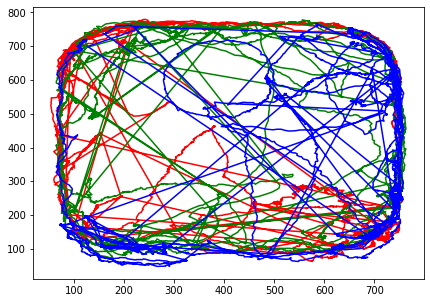

In [118]:
plt.figure(figsize=(7, 5))
centerx_MDN_0 = fly[0]['center','posx']
centery_MDN_0 = fly[0]['center','posy']

plt.plot(centerx_MDN_0, centery_MDN_0, color= 'r', label='All flies')

centerx_MDN_1 = fly[1]['center','posx']
centery_MDN_1 = fly[1]['center','posy']

plt.plot(centerx_MDN_1, centery_MDN_1, color= 'g', label='All flies')

centerx_MDN_2 = fly[2]['center','posx']
centery_MDN_2 = fly[2]['center','posy']

plt.plot(centerx_MDN_2, centery_MDN_2, color= 'b', label='All flies')



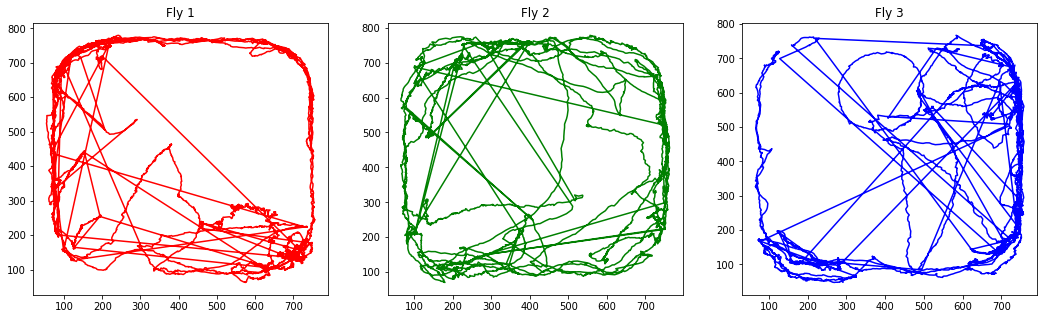

In [114]:
plt.figure(figsize=(18, 5))

plt.subplot(131) 
plt.plot(centerx_MDN_0, centery_MDN_0, color= 'r', label='Fly 1')
plt.title('Fly 1')

plt.subplot(132)
plt.plot(centerx_MDN_1, centery_MDN_1, color= 'g', label='Fly 2')
plt.title('Fly 2')

plt.subplot(133)
plt.plot(centerx_MDN_2, centery_MDN_2, color= 'b', label='Fly 3')
plt.title('Fly 3')
plt.plot

plt.show()

##### part 1b

the forward / backward speed over time

dist = math.exp(pow(fly[0]['center', 'posx'],2), pow